# ConvNet-LSTM classifier

Classify IMDB reviews by their sentiment with a *Convolutional-Bidirectional LSTM Stack*

#### Load dependencies

In [2]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM,Embedding,Dense,Flatten,Dropout,SpatialDropout1D
from keras.layers.wrappers import Bidirectional
from keras.layers import Conv1D,MaxPooling1D
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

#### Set hyperparameters

In [3]:
output_dir = 'model_output/cnnLSTM'

epochs = 4
batch_size = 128

n_dim = 64
n_unique_words = 10000
max_review_length = 200
pad_type = trunc_type = 'pre'
drop_embed = 0.2

n_conv = 64
k_conv = 3
mp_size = 4

n_lstm = 64
drop_lstm = 0.2

#### Load data

In [4]:
(x_train, y_train) , (x_valid, y_valid) = imdb.load_data(num_words = n_unique_words )

#### Preprocess data

In [5]:
x_train = pad_sequences(x_train,maxlen=max_review_length,padding=pad_type,truncating=trunc_type,value=0)
x_valid = pad_sequences(x_valid,maxlen=max_review_length,padding=pad_type,truncating=trunc_type,value=0)

#### Design NN architecture

In [6]:
model = Sequential()
model.add(Embedding(n_unique_words,n_dim,input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(n_conv,k_conv,activation='relu'))
model.add(MaxPooling1D(mp_size))
model.add(Bidirectional(LSTM(n_lstm,dropout=drop_lstm)))
model.add(Dense(1,activation='sigmoid'))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 64)           640000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 64)           12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 718,529
Trainable params: 718,529
Non-trainable params: 0
_________________________________________________________________


#### Configure model

In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [9]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [10]:
model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid,y_valid),callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 83s 3ms/step - loss: 0.4526 - acc: 0.7640 - val_loss: 0.3115 - val_acc: 0.8718
Epoch 2/4
25000/25000 [==============================] - 83s 3ms/step - loss: 0.2420 - acc: 0.9021 - val_loss: 0.3350 - val_acc: 0.8710
Epoch 3/4
25000/25000 [==============================] - 80s 3ms/step - loss: 0.1736 - acc: 0.9351 - val_loss: 0.3328 - val_acc: 0.8580
Epoch 4/4
25000/25000 [==============================] - 83s 3ms/step - loss: 0.1333 - acc: 0.9526 - val_loss: 0.3436 - val_acc: 0.8558


#### Evaluate

In [11]:
model.load_weights(output_dir+'/weights.01.hdf5')

In [12]:
y_hat = model.predict_proba(x_valid)

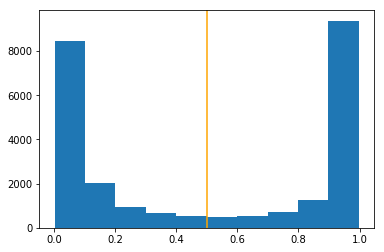

In [13]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5,color='orange')

In [14]:
pct_auc = roc_auc_score(y_valid,y_hat)*100.0

In [15]:
"{:0.2f}".format(pct_auc)

'94.54'